# Libraries 📖

In [29]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%run ./src/data_preprocessing.py

# Load data 📁

In [4]:
datapath = "./data/"
read_data = ReadData(datapath)
dataframe = read_data.read_data()

# Exploratory Data Analysis 📊

In [5]:
data_preprocessing = DataPreprocessing()
dataframe = data_preprocessing.process_data_preprocessing(dataframe)

C:\Users\chenk\JupyterNotebook\Machine-Learning-Development\src\data_preprocessing.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[["Distance", "UOM"]] = dataframe["Cruise Distance"].str.split(pat=' ', n=1, expand=True)
C:\Users\chenk\JupyterNotebook\Machine-Learning-Development\src\data_preprocessing.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[["Distance", "UOM"]] = dataframe["Cruise Distance"].str.split(pat=' ', n=1, expand=True)
C:\Users\chenk\JupyterNotebook\Machine-L

## Data Profiling 

#### This stage I would like to have an idea of combined dataset

In [18]:
# Get a rough idea on the number of rows for the dataframe
dataframe.shape

(102806, 24)

In [19]:
# Following are the first 5 rows of Pre_cruise as sample to ensure 
dataframe.head(5)

,Gender,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,...,Onboard Service,Cleanliness,Ext_Intcode,Cruise Name,Ticket Type,WiFi,Dining,Entertainment,Distance in KM,Age
2,Female,Indirect - Search Engine,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,5.0,...,3.0,NaN,BL713UHBAAN,IAPRAS,Deluxe,NaN,0,0.0,1167.0,25
3,Female,Direct - Company Website,Very important,4.0,4.0,4.0,01/01/2023 0:05,Somewhat important,4.0,4.0,...,2.0,4.0,LB243DMKCFL,Lapras,Deluxe,NaN,0,1.0,280.0,53
4,Male,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:06,Not at all important,2.0,NaN,...,2.0,NaN,LB218CFLOBS,Lapras,Standard,NaN,1,NaN,1843.0,63
5,Male,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:06,Not at all important,2.0,NaN,...,2.0,NaN,LB218CFLOBS,Lapras,Standard,NaN,1,NaN,1843.0,63
6,Male,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:11,Not at all important,2.0,1.0,...,2.0,1.0,LB218CFLOBS,Lapras,Standard,NaN,1,NaN,1843.0,63


In [20]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102806 entries, 2 to 141537
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Gender                                      92495 non-null   object 
 1   Source of Traffic                           102806 non-null  object 
 2   Onboard Wifi Service                        87846 non-null   object 
 3   Embarkation/Disembarkation time convenient  90850 non-null   float64
 4   Ease of Online booking                      88588 non-null   float64
 5   Gate location                               89642 non-null   float64
 6   Logging                                     102806 non-null  object 
 7   Onboard Dining Service                      89942 non-null   object 
 8   Online Check-in                             90747 non-null   float64
 9   Cabin Comfort                               84913 non-null   float64
 10  O

In [21]:
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
Embarkation/Disembarkation time convenient,90850.0,3.057733,1.523713,0.0,2.0,3.0,4.0,5.0
Ease of Online booking,88588.0,2.760938,1.397638,0.0,2.0,3.0,4.0,5.0
Gate location,89642.0,2.978459,1.274968,1.0,2.0,3.0,4.0,5.0
Online Check-in,90747.0,3.246499,1.350410,0.0,2.0,3.0,4.0,5.0
Cabin Comfort,84913.0,3.437036,1.321591,0.0,2.0,4.0,5.0,5.0
Cabin service,92222.0,3.381991,1.286719,0.0,2.0,4.0,4.0,5.0
Baggage handling,84890.0,3.632289,1.179029,1.0,3.0,4.0,5.0,5.0
Port Check-in Service,91828.0,3.308577,1.269444,1.0,3.0,3.0,4.0,5.0
Onboard Service,88585.0,3.642795,1.178160,0.0,3.0,4.0,5.0,5.0
Cleanliness,86338.0,3.284440,1.314959,0.0,2.0,3.0,4.0,5.0


In [22]:
dataframe.isna().sum()

Gender                                        10311
Source of Traffic                                 0
Onboard Wifi Service                          14960
Embarkation/Disembarkation time convenient    11956
Ease of Online booking                        14218
Gate location                                 13164
Logging                                           0
Onboard Dining Service                        12864
Online Check-in                               12059
Cabin Comfort                                 17893
Onboard Entertainment                         12187
Cabin service                                 10584
Baggage handling                              17916
Port Check-in Service                         10978
Onboard Service                               14221
Cleanliness                                   16468
Ext_Intcode                                       0
Cruise Name                                   12274
Ticket Type                                       0
WiFi        

#### From the above, I quickly inspecting the structure and content of a DataFrame
#### Looking at the above huge missing data is my concern. Given that there are 133,746 records, with 20,293 missing data in Baggage handling that is 15.1%.
#### WiFi & Entertainment contribute to 52% of missing data, I suggest not to use these columns during modelling
#### I notice there are 2 Ext_Intcodes from each dataset. If they are the same then drop one.
#### DOB is an object datatype rather than a datetime.
#### Cruise Duration contain both KM and Miles which need to standardise urgently before proceeding into any visualisation which can cause inaccuracy.

## Data Understanding

In [15]:
def plot_hists_from_dataframe(dataframe: pd.core.frame.DataFrame, dependent_features: list):
    """
        This function will produce a histogram of the each of the element found in the dependent_features that resides in
        DataFrame. The significance of this function is to list out the count of every value in dependent_features. From the
        the bar, we can lookout for dirty data and perform data cleansing.
 
        Args:
            dataframe (Dataframe): The dataframe which contain the column to be examined.
            dependent_features (list): The column name to plot the histogram.
 
        Returns:
            NIL.
    """
    for col_name in dependent_features:
        value_counts = dataframe[col_name].value_counts()
        plt.figure(figsize=(10, 5))
        bars = plt.bar(value_counts.index, value_counts.values)
        plt.title(f'Distribution of {col_name}')
        plt.xlabel(col_name)
        plt.ylabel('Count')
        plt.xticks(rotation=90)  
        for bar, count in zip(bars, value_counts.values):
            plt.text(bar.get_x() + bar.get_width() / 2, count, str(count), ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

#### This stage, I like to see the dirty data that existed in each Categorical data and their count

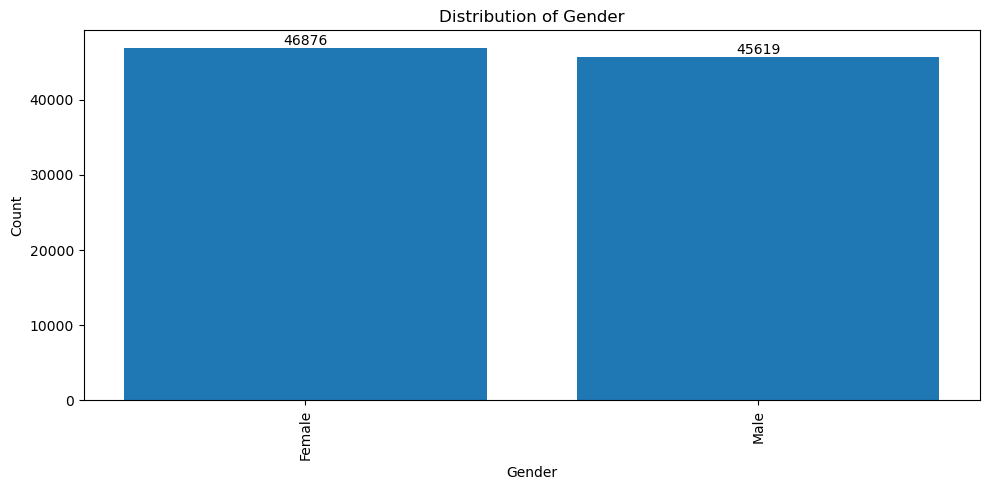

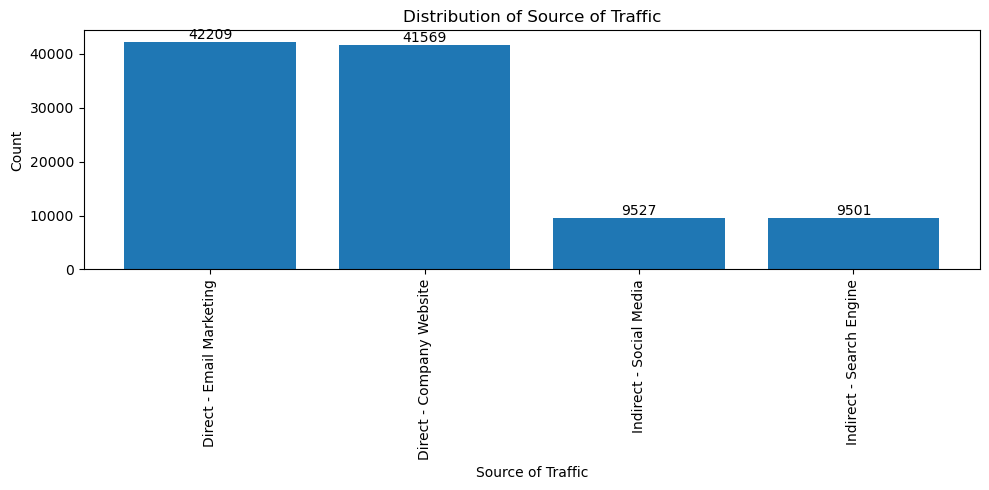

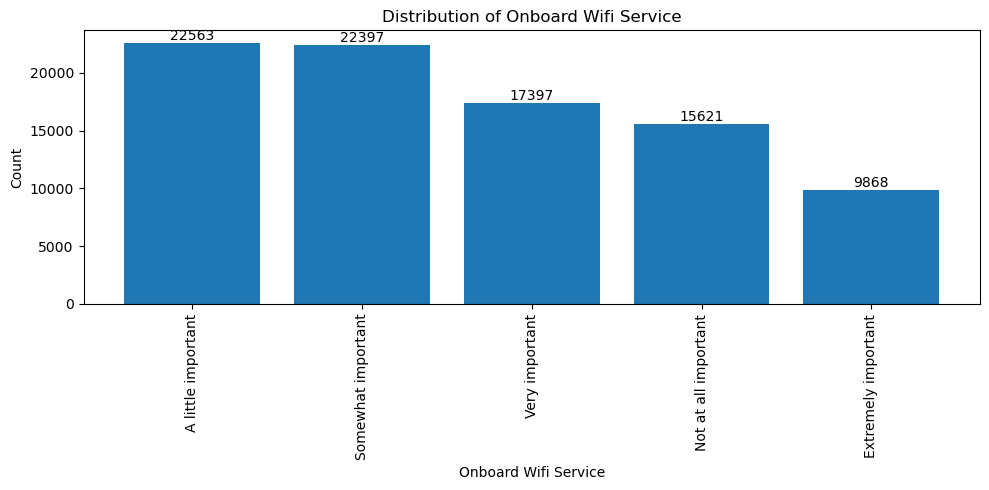

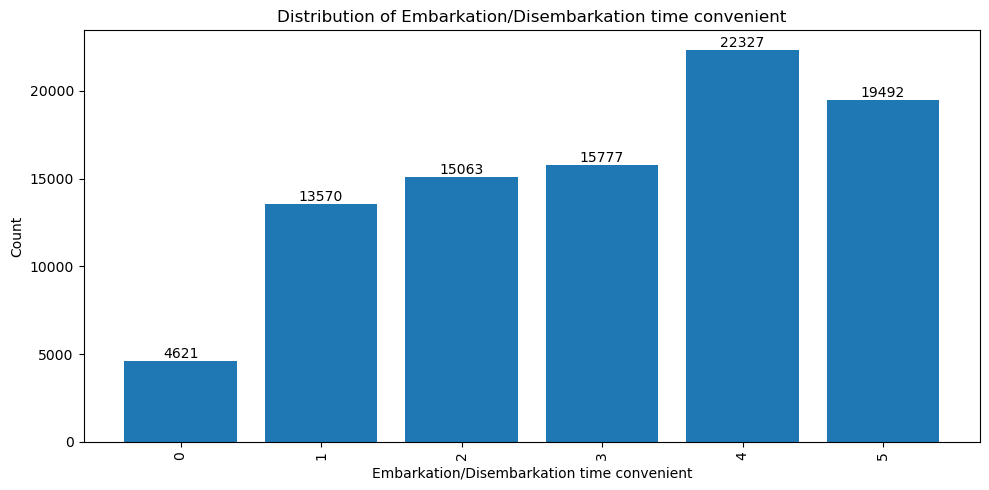

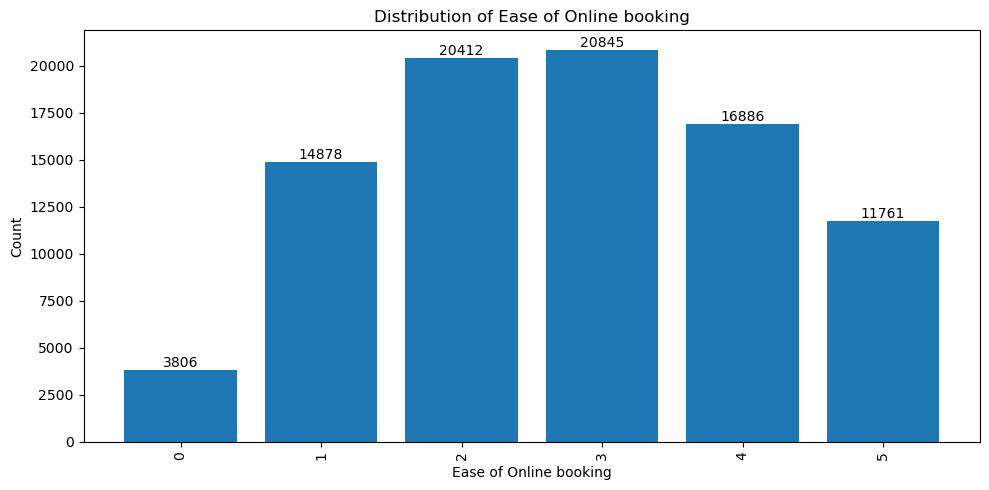

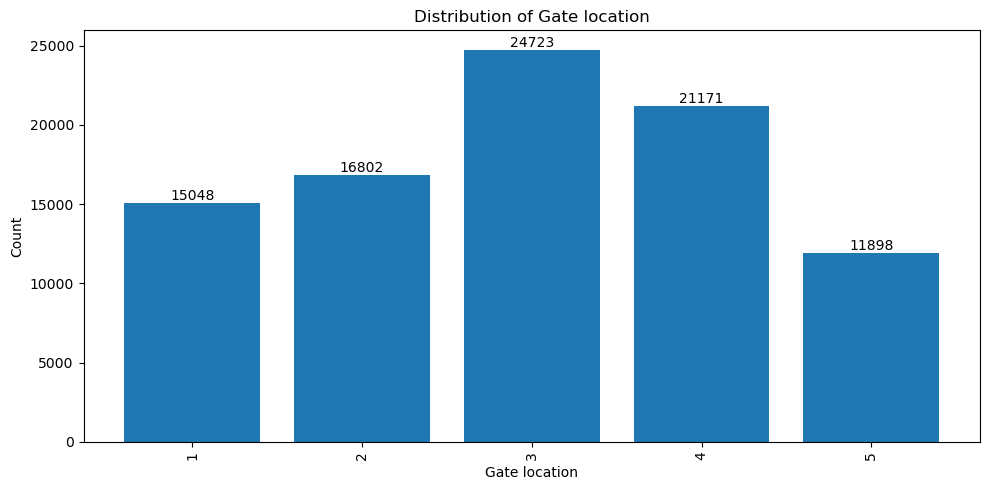

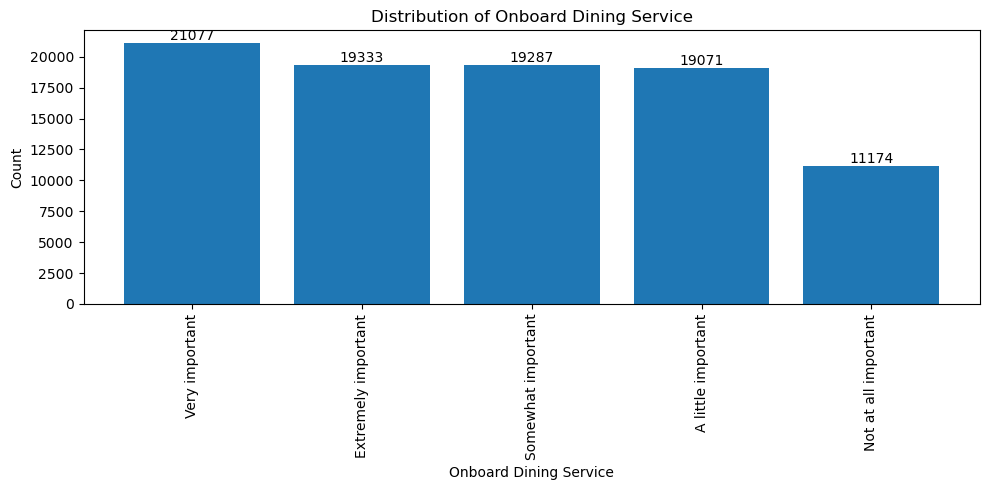

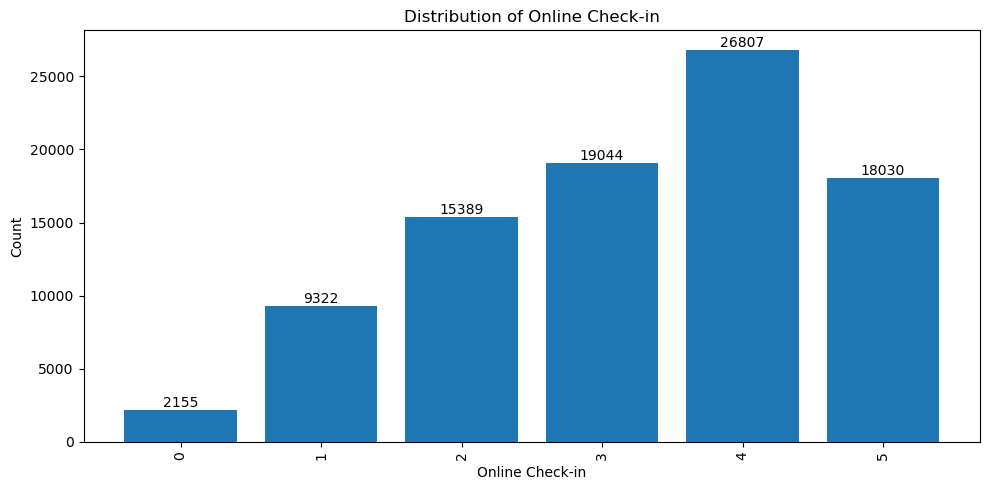

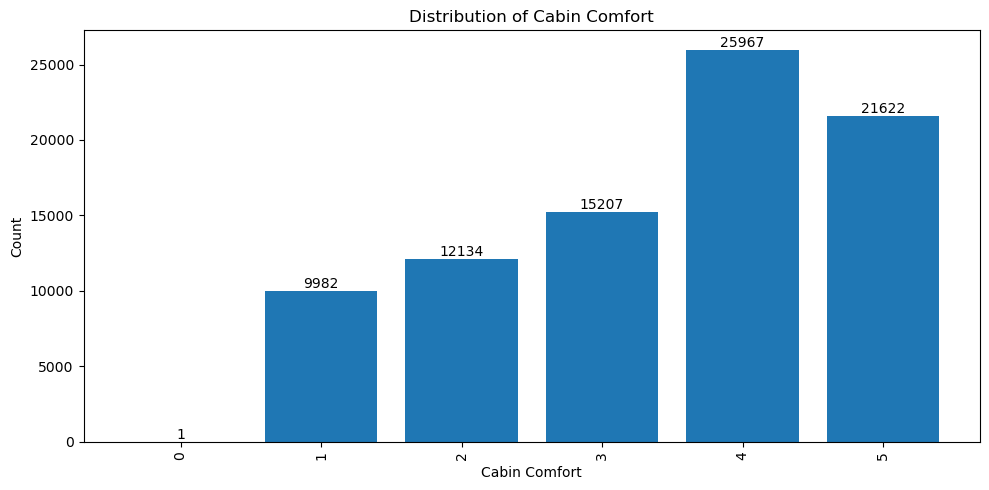

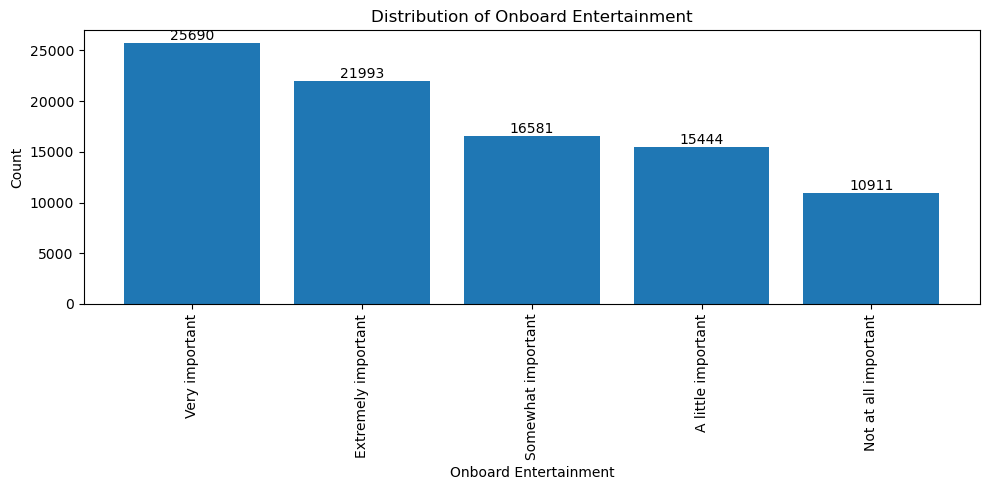

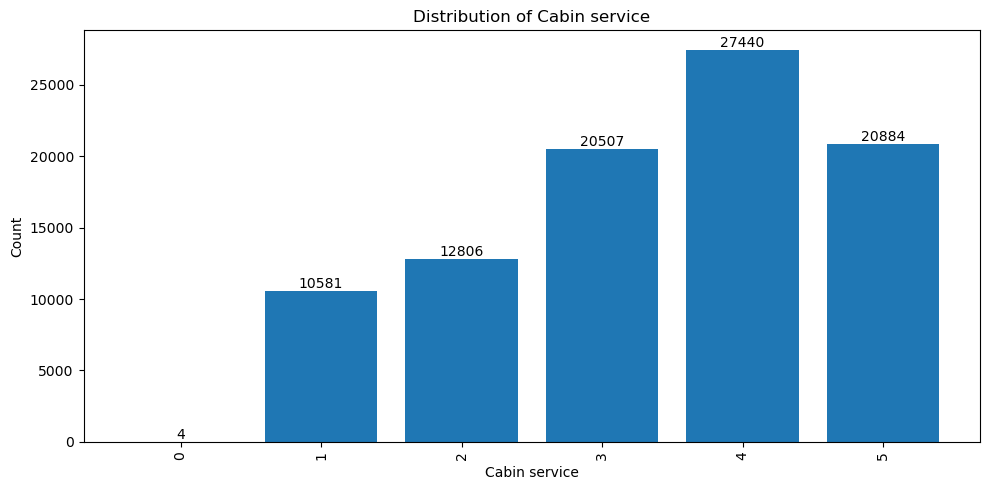

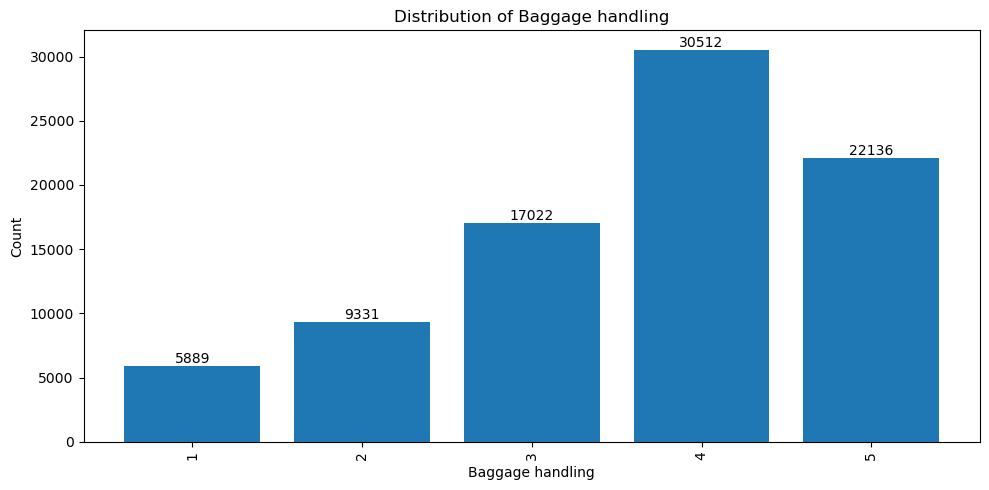

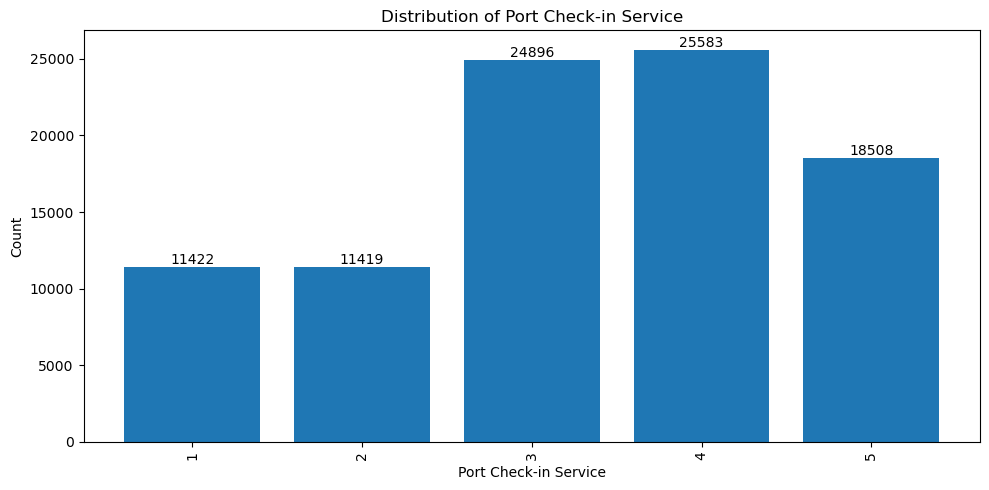

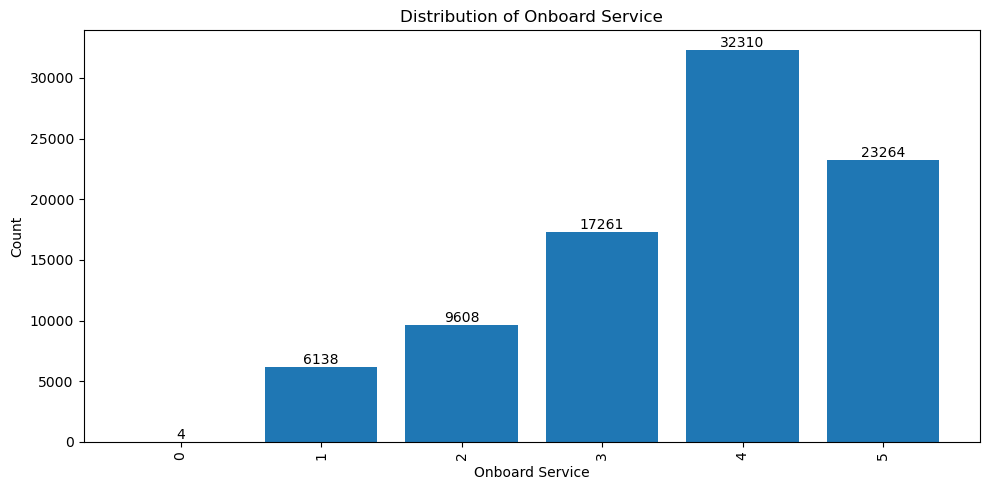

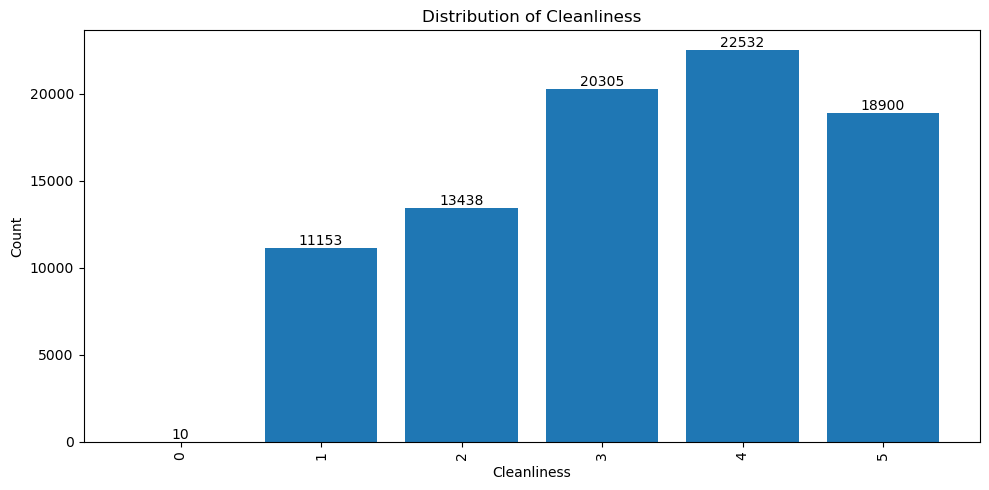

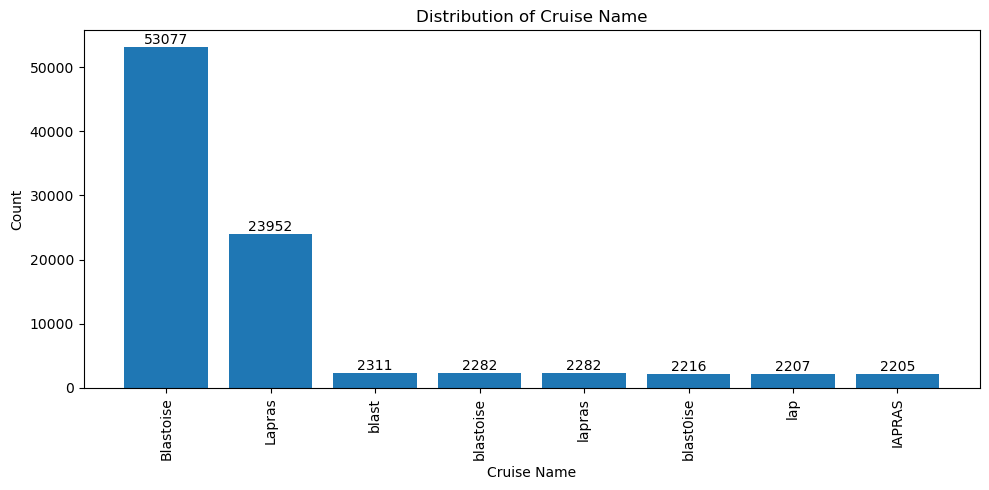

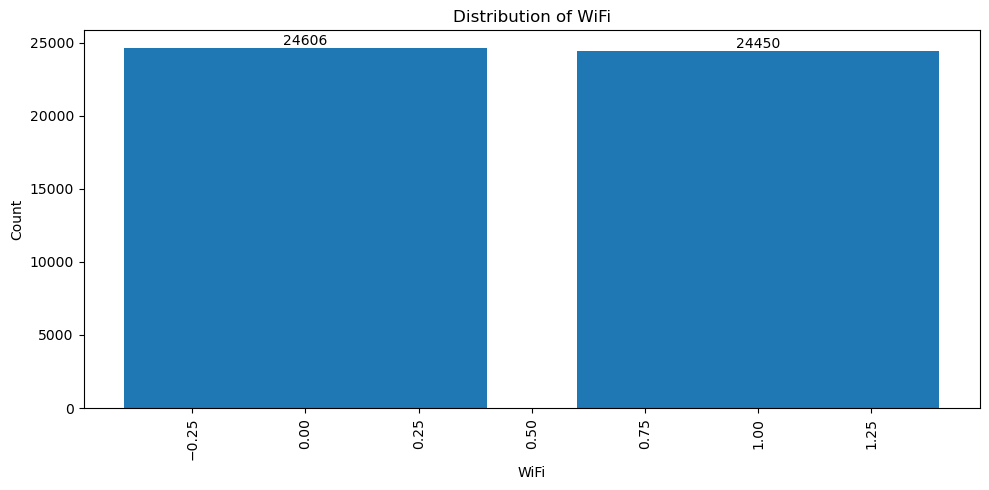

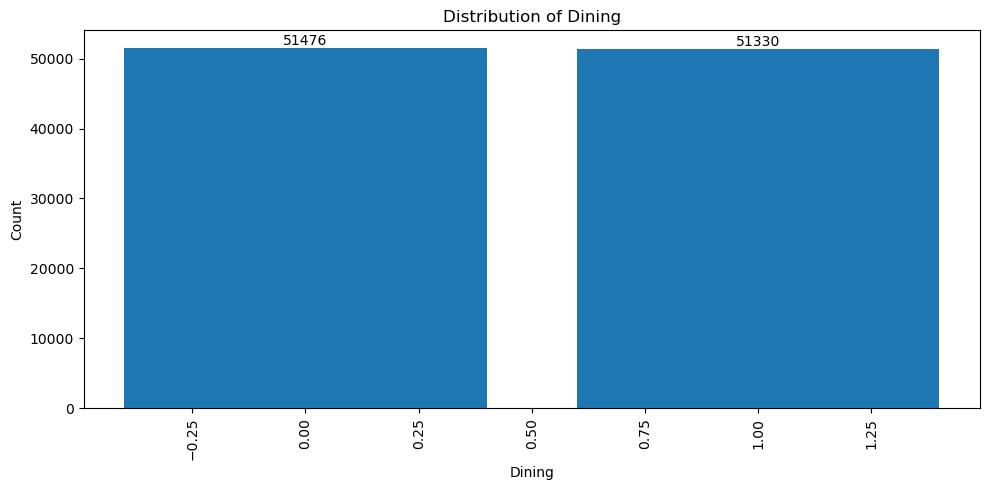

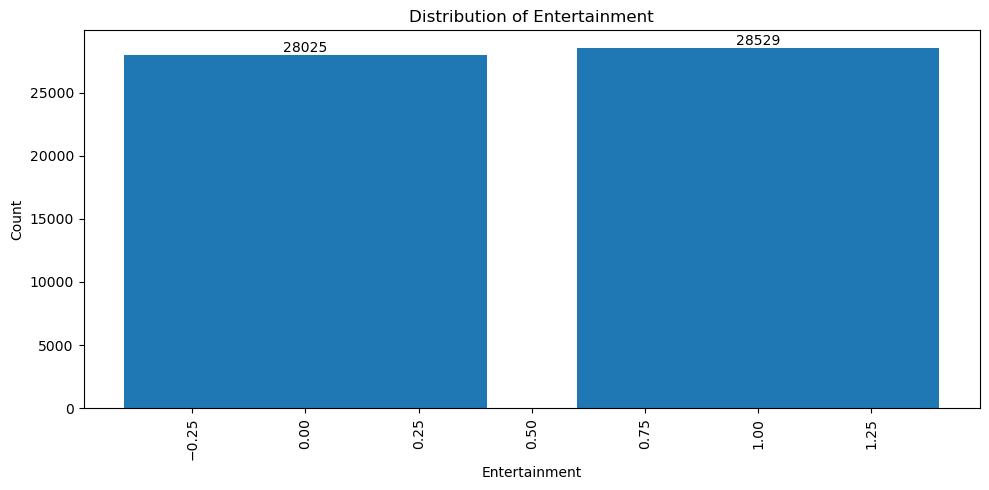

In [23]:
# Visualise a histogram on the every value in each feature in the list  
column_names = dataframe.columns.tolist()
# Omit IDs, working and continuous variables from the list 
elements_to_remove = ["Date of Birth","Ext_Intcode","Logging","Distance in KM","Ticket Type","Age"] 
column_names = list(filter(lambda x: x not in elements_to_remove, column_names))
plot_hists_from_dataframe(dataframe, column_names)

<div style="background-color: #f0f9ff; border-left: 6px solid #0ea5e9; font-size: 100%; padding: 10px;">
    <h3 style="color: #27374D; font-size: 18px; margin-top: 0; margin-bottom: 10px;">📉  Observation: </h3>
    <ul>
        <li>Gender
            <ul>
                <li>non-numeric Binary variable. Need transform for Male to 1 and Female to 0.</li>
                <li>Male is slightly more than Female, I prefer to use random so not to in create distortion.</li>
                <li>If I impute to Male, because it is more than female, it distorts the distribution</li>
            </ul>
        </li>
        <li>Date Of Birth
            <ul>
                <li>This field transforms to Age. Age is a numeric Continuous variable</li>
                <li>For missing age, I use median.</li>
                <li>I consider to use bin to categorise, as the older the passenger is, the better ticket typehe purchase</li>
            </ul>
        </li>
        <li>Source of Traffic
            <ul>
                <li>non-numeric nominal variable - Need to use One Hot Key Encoder</li>
                <li>No missing value.</li>
            </ul>
        </li>
        <li>Onboard Wifi Service
            <ul>
                <li>This is an non-numeric ordinal variable. So need to use ordinal Encoder.</li>
                <li>Since majority thought that Wifi is between "A little impt" and "Somewhat impt", if, I impute to mode, which is "A little impt", it should not distort the distribution much.</li>
            </ul>
        </li>
        <li>Embarkation/Disembarkation time convenient
            <ul>
                <li>This is an numeric ordinal variable. No further action required.</li>                    
                <li>Since slight higher trend towards is very important and extreme impt , I impute missing value with mode.</li>
            </ul>
        </li>       
        <li>Ease of Online booking
            <ul>
                <li>This is an numeric ordinal variable. No further action required.</li>
                <li>Since slight higher trend towards is a little impt and somewhat impt, I impute missing value with mode.</li>
            </ul>
        </li>
        <li>Gate location
            <ul>
                <li>This is an numeric ordinal variable. No further action required.</li>
                <li>Since slight higher trend towards is a somewhat impt and very impt, I impute missing value with mode.</li>
            </ul>
        </li>
        <li>Onboard Dining Service
            <ul>
                <li>This is an non-numeric ordinal variable. So need to use ordinal Encoder.</li>
                <li>Since slight higher trend towards is a Very impt and extremely impt, I impute missing value with mode.</li>
            </ul>
        </li> 
        <li>Online Check-in
            <ul>
                <li>This is an numeric ordinal variable. No further action required.</li>
                <li>Since slight higher trend towards is a Very impt, I impute missing value with mode.</li>
            </ul>
        </li>
        <li>Cabin Comfort
            <ul>
                <li>This is an numeric ordinal variable. No further action required.</li>
                <li>Since slight higher trend towards is a Very impt, I impute missing value with mode.</li>
            </ul>
        </li>
        <li>Onboard Entertainment
            <ul>
                <li>This is an non-numeric ordinal variable. So need to use ordinal Encoder.</li>
                <li>Since slight higher trend towards is a Very impt and extremely impt, I impute missing value with mode.</li>
            </ul>
        </li>
        <li>Cabin service
            <ul>
                <li>This is an numeric ordinal variable. No further action required.</li>
                <li>Since slight higher trend towards is a Very impt and extremely impt, I impute missing value with mode.</li>
            </ul>
        </li>
        <li>Baggage handling
            <ul>
                <li>This is an numeric ordinal variable. No further action required.</li>
                <li>Since slight higher trend towards is a Very impt, I impute missing value with mode.</li>
            </ul>
        </li>
        <li>Port Check-in Service
            <ul>
                <li>This is an numeric ordinal variable. No further action required.</li>
                <li>Since slight higher trend towards is a somewhat impt and Very impt, I impute missing value with mode.</li>
            </ul>
        </li>
        <li>Onboard Service
            <ul>
                <li>This is an numeric ordinal variable. No further action required.</li>
                <li>Since slight higher trend towards is a Very impt and Extremely impt, I impute missing value with mode.</li>
            </ul>
        </li>
        <li>Cleanliness
            <ul>
                <li>This is an numeric ordinal variable. No further action required.</li>
                <li>Since slight higher trend towards is a Very impt and somewhat impt, I impute missing value with mode.</li>
            </ul>
        </li>
        <li>Cruise Name
            <ul>
                <li>Group blast, blast0ise, blastoise under Blastoise</li>
                <li>Group IAPRAS, lap, lapras under Lapras</li>
                <li>All missing value group under Blastoise since most taking Blastoise</li>
                <li>non-numeric Binary variable. Need transform for Blastoise to 1 and Lapras to 0.</li>
            </ul>
        </li>
        <li>Ticket Type
            <ul>
                <li>Since this is the dependent variable, any missing value should be removed.</li>
                <li>Need to use Label encoder since it is the Dependent variable</li>                    
            </ul>
        </li>
        <li>WiFi, Entertainment
            <ul>
                <li>I like to exclude these features from modelling as there are too many missing values. </li>            
            </ul>
        </li>
        <li>Cruise Distance
            <ul>
                <li>Standard to Distance in KM</li>
                <li>Impute missing to Mean.
                </li>
            </ul>
        </li>        
</div>


In [24]:
def plt_axis_name(x_column,y_column, dataframe):  
    plt.title(f'Relationship between {x_column} and {y_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)

In [25]:
def volin_plot(x_column, y_column, dataframe):
    plt.figure(figsize=(8, 6))     
    sns.violinplot(x=x_column, y=y_column, data=dataframe)
    plt_axis_name(x_column,y_column, dataframe)       
    plt.show()

In [26]:
def box_plot(x_column, y_column, dataframe):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=x_column, y=y_column, data=dataframe)
    plt_axis_name(x_column,y_column, dataframe)
    plt.show()

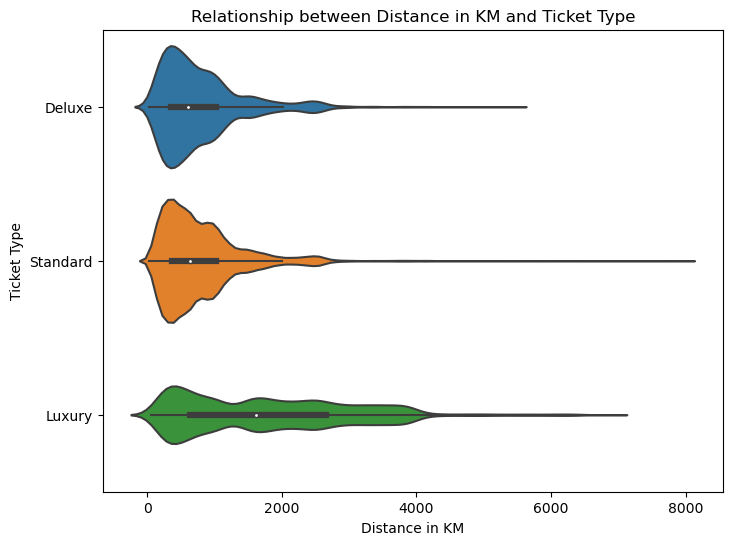

In [31]:
volin_plot('Distance in KM','Ticket Type', dataframe)

#### From the above volin plot, I can gather that
1. Less people travel using Luxury as compared to Standard and Deluxe.
2. For longer distance, people choose Standard and Deluxe over Luxury. 

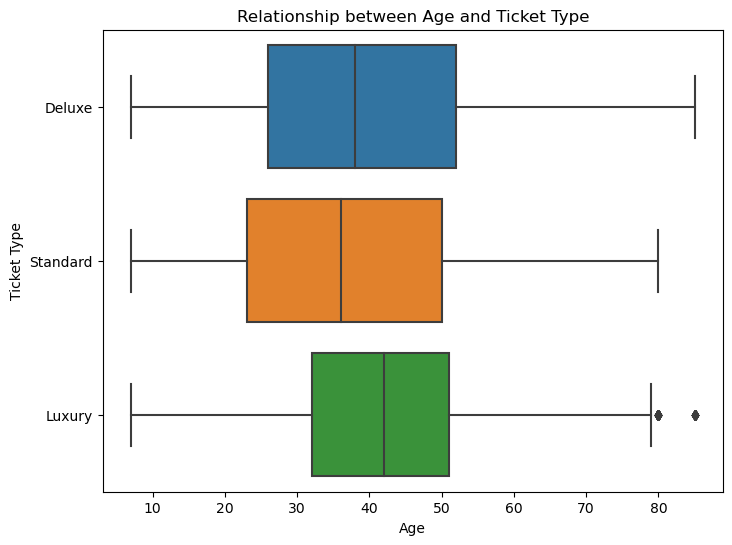

In [33]:
box_plot('Age','Ticket Type', dataframe)

#### From the above boxplot, I can gather that
1. As the older you are the more you can afford higher class. This can be seen by the mean of Luxury higher than Deluxe which is in turn higher than Standard. 
2. Some outliners in Luxury class

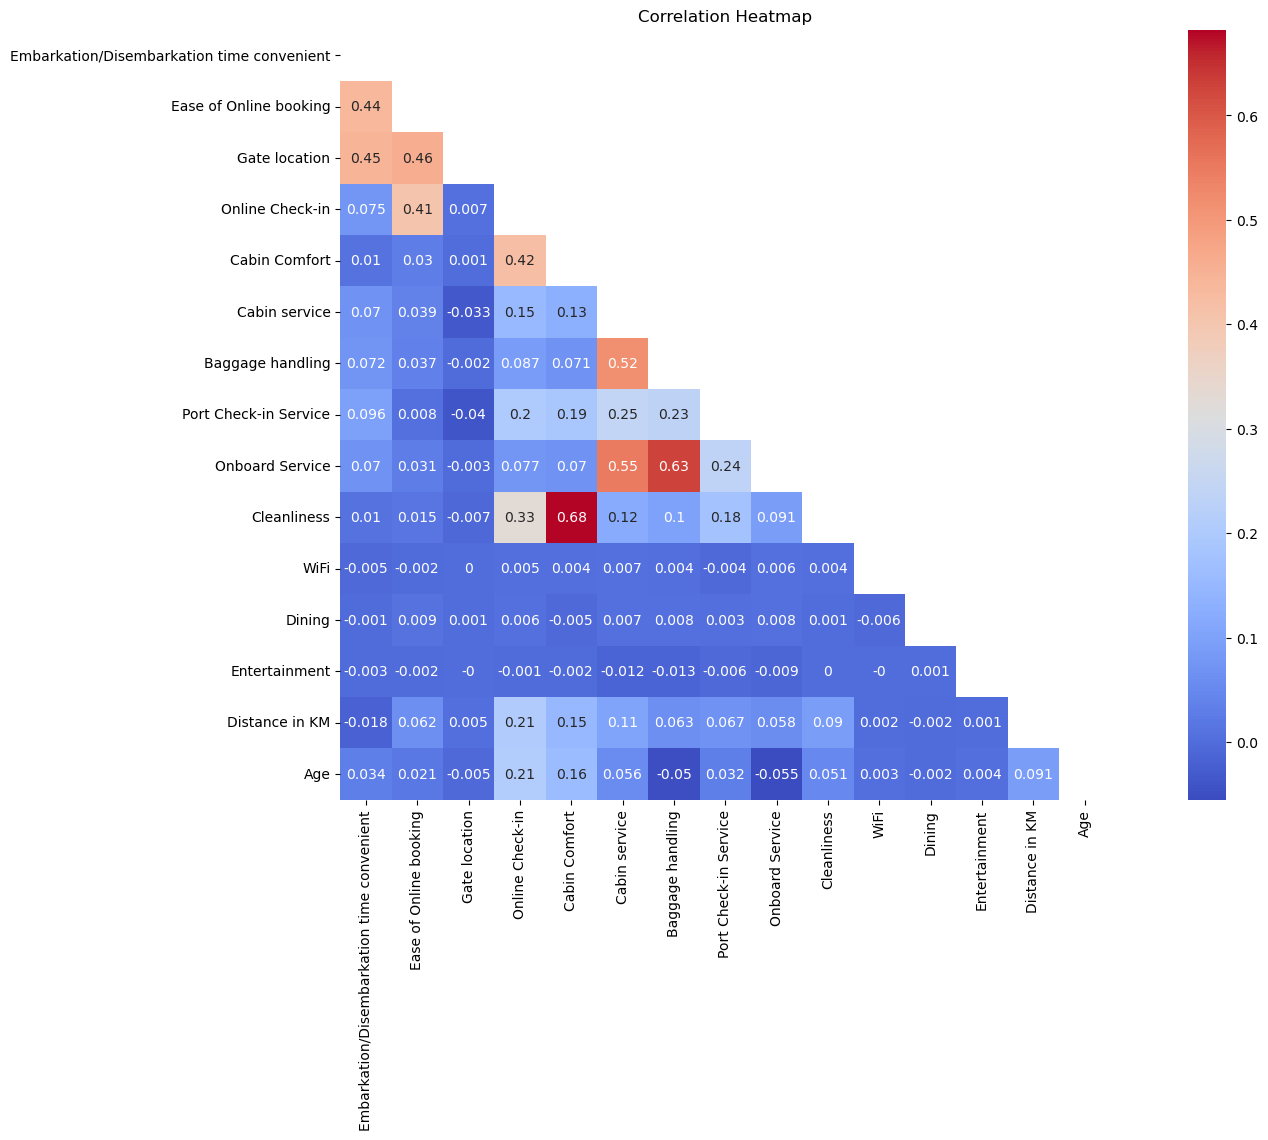

In [35]:
## Correlation table
corr = round(dataframe.corr(numeric_only=True),3)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True, cmap="coolwarm", mask=mask, square=True)
plt.title('Correlation Heatmap')
plt.show()

In [39]:
%run ./src/feature_engineering.py
feature_engineering = FeatureEngineer(dataframe)
dataframe = feature_engineering.fix_typo_error()
dataframe = feature_engineering.drop_ID_cols()
dataframe = feature_engineering.convert_features_to_numeric()
dataframe = feature_engineering.process_impute_missing_data()

In [ ]:
df_cruise.info()

In [ ]:
# Define Class as Target Variable, and the rest as feature variable
X = df_data.drop("class", axis=1)     # everything except 'class' column
y = df_data['class']

# Define the train dataset as 70% and test dataset as 30%
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

# Confirm that the records returned for Train is about 70% and Test is about 30%
print(f"'X' shape: {X_train.shape}")
print(f"'y' shape: {X_test.shape}")